 Lambda School Data Science, Unit 2: Predictive Modeling

 # Regression & Classification, Module 3

 ## Assignment

 We're going back to our other **New York City** real estate dataset. Instead of predicting apartment rents, you'll predict property sales prices.

 But not just for condos in Tribeca...

 Instead, predict property sales prices for **One Family Dwellings** (`BUILDING_CLASS_CATEGORY` == `'01 ONE FAMILY DWELLINGS'`).

 Use a subset of the data where the **sale price was more than \\$100 thousand and less than $2 million.**

 The [NYC Department of Finance](https://www1.nyc.gov/site/finance/taxes/property-rolling-sales-data.page) has a glossary of property sales terms and NYC Building Class Code Descriptions. The data comes from the [NYC OpenData](https://data.cityofnewyork.us/browse?q=NYC%20calendar%20sales) portal.

 - [ ] Do train/test split. Use data from January — March 2019 to train. Use data from April 2019 to test.
 - [ ] Do one-hot encoding of categorical features.
 - [ ] Do feature selection with `SelectKBest`.
 - [ ] Do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html).
 - [ ] Fit a ridge regression model with multiple features.
 - [ ] Get mean absolute error for the test set.
 - [ ] As always, commit your notebook to your fork of the GitHub repo.


 ## Stretch Goals
 - [ ] Add your own stretch goal(s) !
 - [ ] Instead of `RidgeRegression`, try `LinearRegression`. Depending on how many features you select, your errors will probably blow up! 💥
 - [ ] Instead of `RidgeRegression`, try [`RidgeCV`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html).
 - [ ] Learn more about feature selection:
	 - ["Permutation importance"](https://www.kaggle.com/dansbecker/permutation-importance)
	 - [scikit-learn's User Guide for Feature Selection](https://scikit-learn.org/stable/modules/feature_selection.html)
	 - [mlxtend](http://rasbt.github.io/mlxtend/) library
	 - scikit-learn-contrib libraries: [boruta_py](https://github.com/scikit-learn-contrib/boruta_py) & [stability-selection](https://github.com/scikit-learn-contrib/stability-selection)
	 - [_Feature Engineering and Selection_](http://www.feat.engineering/) by Kuhn & Johnson.
 - [ ] Try [statsmodels](https://www.statsmodels.org/stable/index.html) if you’re interested in more inferential statistical approach to linear regression and feature selection, looking at p values and 95% confidence intervals for the coefficients.
 - [ ] Read [_An Introduction to Statistical Learning_](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf), Chapters 1-3, for more math & theory, but in an accessible, readable way.
 - [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html).

In [2]:
import pandas as pd
# import pandas_profiling

# Read New York City property sales data
df = pd.read_csv('./data/condos/NYC_Citywide_Rolling_Calendar_Sales.csv')

# Change column names: replace spaces with underscores
df.columns = [col.replace(' ', '_') for col in df]

# SALE_PRICE was read as strings.
# Remove symbols, convert to integer
df['SALE_PRICE'] = (
	df['SALE_PRICE']
	.str.replace('$','')
	.str.replace('-','')
	.str.replace(',','')
	.astype(int)
)



In [3]:
# BOROUGH is a numeric column, but arguably should be a categorical feature,
# so convert it from a number to a string
df['BOROUGH'] = df['BOROUGH'].astype(str)



In [4]:
# Reduce cardinality for NEIGHBORHOOD feature

# Get a list of the top 10 neighborhoods
top10 = df['NEIGHBORHOOD'].value_counts()[:10].index

# At locations where the neighborhood is NOT in the top 10, 
# replace the neighborhood with 'OTHER'
df.loc[~df['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'


In [5]:
import pandas
print(df.shape)
df.isna().sum()
# df.loc[7]


(23040, 21)


BOROUGH                               0
NEIGHBORHOOD                          0
BUILDING_CLASS_CATEGORY               0
TAX_CLASS_AT_PRESENT                  1
BLOCK                                 0
LOT                                   0
EASE-MENT                         23040
BUILDING_CLASS_AT_PRESENT             1
ADDRESS                               0
APARTMENT_NUMBER                  17839
ZIP_CODE                              1
RESIDENTIAL_UNITS                     1
COMMERCIAL_UNITS                      1
TOTAL_UNITS                           1
LAND_SQUARE_FEET                     53
GROSS_SQUARE_FEET                     1
YEAR_BUILT                           35
TAX_CLASS_AT_TIME_OF_SALE             0
BUILDING_CLASS_AT_TIME_OF_SALE        0
SALE_PRICE                            0
SALE_DATE                             0
dtype: int64

In [6]:

df_ofd = df[(df['BUILDING_CLASS_CATEGORY'] == '01 ONE FAMILY DWELLINGS') &
			(df['SALE_PRICE'] > 100000) &
			(df['SALE_PRICE'] < 2000000)]
df_ofd['sale_dt'] = pandas.to_datetime(df_ofd['SALE_DATE'])


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [7]:
print(df_ofd.isna().sum())

print(df_ofd.shape)
df_ofd = df_ofd.dropna(subset=['ZIP_CODE'])
print(df_ofd.shape)
df_ofd = df_ofd.dropna(axis=1)
print(df_ofd.shape)

df_ofd.isna().sum()


BOROUGH                              0
NEIGHBORHOOD                         0
BUILDING_CLASS_CATEGORY              0
TAX_CLASS_AT_PRESENT                 0
BLOCK                                0
LOT                                  0
EASE-MENT                         3151
BUILDING_CLASS_AT_PRESENT            0
ADDRESS                              0
APARTMENT_NUMBER                  3150
ZIP_CODE                             0
RESIDENTIAL_UNITS                    0
COMMERCIAL_UNITS                     0
TOTAL_UNITS                          0
LAND_SQUARE_FEET                     0
GROSS_SQUARE_FEET                    0
YEAR_BUILT                           0
TAX_CLASS_AT_TIME_OF_SALE            0
BUILDING_CLASS_AT_TIME_OF_SALE       0
SALE_PRICE                           0
SALE_DATE                            0
sale_dt                              0
dtype: int64
(3151, 22)
(3151, 22)
(3151, 20)


BOROUGH                           0
NEIGHBORHOOD                      0
BUILDING_CLASS_CATEGORY           0
TAX_CLASS_AT_PRESENT              0
BLOCK                             0
LOT                               0
BUILDING_CLASS_AT_PRESENT         0
ADDRESS                           0
ZIP_CODE                          0
RESIDENTIAL_UNITS                 0
COMMERCIAL_UNITS                  0
TOTAL_UNITS                       0
LAND_SQUARE_FEET                  0
GROSS_SQUARE_FEET                 0
YEAR_BUILT                        0
TAX_CLASS_AT_TIME_OF_SALE         0
BUILDING_CLASS_AT_TIME_OF_SALE    0
SALE_PRICE                        0
SALE_DATE                         0
sale_dt                           0
dtype: int64

In [8]:
df_ofd.head()



,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,BUILDING_CLASS_AT_PRESENT,ADDRESS,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE,sale_dt
44,3,OTHER,01 ONE FAMILY DWELLINGS,1,5495,801,A9,4832 BAY PARKWAY,11230.0,1.0,0.0,1.0,"6,800",1325.0,1930.0,1,A9,550000,01/01/2019,2019-01-01
61,4,OTHER,01 ONE FAMILY DWELLINGS,1,7918,72,A1,80-23 232ND STREET,11427.0,1.0,0.0,1.0,"4,000",2001.0,1940.0,1,A1,200000,01/01/2019,2019-01-01
78,2,OTHER,01 ONE FAMILY DWELLINGS,1,4210,19,A1,1260 RHINELANDER AVE,10461.0,1.0,0.0,1.0,"3,500",2043.0,1925.0,1,A1,810000,01/02/2019,2019-01-02
108,3,OTHER,01 ONE FAMILY DWELLINGS,1,5212,69,A1,469 E 25TH ST,11226.0,1.0,0.0,1.0,"4,000",2680.0,1899.0,1,A1,125000,01/02/2019,2019-01-02
111,3,OTHER,01 ONE FAMILY DWELLINGS,1,7930,121,A5,5521 WHITTY LANE,11203.0,1.0,0.0,1.0,"1,710",1872.0,1940.0,1,A5,620000,01/02/2019,2019-01-02


In [9]:
import category_encoders
from typing import Optional
import numpy

def clean(	frame:pandas.DataFrame, 
			cols:Optional[list] = None,
			exclude_cols:Optional[list] = None,
			max_cardinality:Optional[int] = None) -> pandas.DataFrame:
	"""
	Cleans and one-hot encodes the dataframe.
	
	Args:
		frame (pandas.DataFrame): Dataframe to clean
		cols (list, optional): Columns to one-hot encode. Defaults to all string columns.
		exclude_cols (list, optional): Columns to skip one-hot encoding. Defaults to None.
		max_cardinality (int, optional): Maximum cardinality of columns to encode. Defaults to no maximum cardinality.
	
	Returns:
		pandas.DataFrame: The cleaned dataframe.
	"""


	cleaned = frame.copy()

	if cols is None: cols = list(cleaned.columns[cleaned.dtypes=='object'])

	if exclude_cols is not None:
		for col in exclude_cols:
			cols.remove(col)

	if max_cardinality is not None:
		described = cleaned[cols].describe(exclude=[numpy.number])
		cols = list(described.columns[described.loc['unique'] <= max_cardinality])

	encoder = category_encoders.OneHotEncoder(return_df=True, use_cat_names=True, cols=cols)
	cleaned = encoder.fit_transform(cleaned)

	return(cleaned)


In [10]:

cleaned = clean(df_ofd, max_cardinality=100, exclude_cols=['SALE_DATE'])


In [11]:
list(cleaned.columns)


['BOROUGH_3',
 'BOROUGH_4',
 'BOROUGH_2',
 'BOROUGH_5',
 'BOROUGH_1',
 'NEIGHBORHOOD_OTHER',
 'NEIGHBORHOOD_FLUSHING-NORTH',
 'NEIGHBORHOOD_EAST NEW YORK',
 'NEIGHBORHOOD_BEDFORD STUYVESANT',
 'NEIGHBORHOOD_FOREST HILLS',
 'NEIGHBORHOOD_BOROUGH PARK',
 'NEIGHBORHOOD_ASTORIA',
 'BUILDING_CLASS_CATEGORY_01 ONE FAMILY DWELLINGS',
 'TAX_CLASS_AT_PRESENT_1',
 'TAX_CLASS_AT_PRESENT_1D',
 'BLOCK',
 'LOT',
 'BUILDING_CLASS_AT_PRESENT_A9',
 'BUILDING_CLASS_AT_PRESENT_A1',
 'BUILDING_CLASS_AT_PRESENT_A5',
 'BUILDING_CLASS_AT_PRESENT_A0',
 'BUILDING_CLASS_AT_PRESENT_A2',
 'BUILDING_CLASS_AT_PRESENT_A3',
 'BUILDING_CLASS_AT_PRESENT_S1',
 'BUILDING_CLASS_AT_PRESENT_A4',
 'BUILDING_CLASS_AT_PRESENT_A6',
 'BUILDING_CLASS_AT_PRESENT_A8',
 'BUILDING_CLASS_AT_PRESENT_B2',
 'BUILDING_CLASS_AT_PRESENT_S0',
 'BUILDING_CLASS_AT_PRESENT_B3',
 'ADDRESS',
 'ZIP_CODE',
 'RESIDENTIAL_UNITS',
 'COMMERCIAL_UNITS',
 'TOTAL_UNITS',
 'LAND_SQUARE_FEET',
 'GROSS_SQUARE_FEET',
 'YEAR_BUILT',
 'TAX_CLASS_AT_TIME_OF_SALE

In [12]:

target = 'SALE_PRICE'
features = cleaned.columns[cleaned.dtypes!='object'].drop([target, 'sale_dt'])


In [13]:
list(features)


['BOROUGH_3',
 'BOROUGH_4',
 'BOROUGH_2',
 'BOROUGH_5',
 'BOROUGH_1',
 'NEIGHBORHOOD_OTHER',
 'NEIGHBORHOOD_FLUSHING-NORTH',
 'NEIGHBORHOOD_EAST NEW YORK',
 'NEIGHBORHOOD_BEDFORD STUYVESANT',
 'NEIGHBORHOOD_FOREST HILLS',
 'NEIGHBORHOOD_BOROUGH PARK',
 'NEIGHBORHOOD_ASTORIA',
 'BUILDING_CLASS_CATEGORY_01 ONE FAMILY DWELLINGS',
 'TAX_CLASS_AT_PRESENT_1',
 'TAX_CLASS_AT_PRESENT_1D',
 'BLOCK',
 'LOT',
 'BUILDING_CLASS_AT_PRESENT_A9',
 'BUILDING_CLASS_AT_PRESENT_A1',
 'BUILDING_CLASS_AT_PRESENT_A5',
 'BUILDING_CLASS_AT_PRESENT_A0',
 'BUILDING_CLASS_AT_PRESENT_A2',
 'BUILDING_CLASS_AT_PRESENT_A3',
 'BUILDING_CLASS_AT_PRESENT_S1',
 'BUILDING_CLASS_AT_PRESENT_A4',
 'BUILDING_CLASS_AT_PRESENT_A6',
 'BUILDING_CLASS_AT_PRESENT_A8',
 'BUILDING_CLASS_AT_PRESENT_B2',
 'BUILDING_CLASS_AT_PRESENT_S0',
 'BUILDING_CLASS_AT_PRESENT_B3',
 'ZIP_CODE',
 'RESIDENTIAL_UNITS',
 'COMMERCIAL_UNITS',
 'TOTAL_UNITS',
 'GROSS_SQUARE_FEET',
 'YEAR_BUILT',
 'TAX_CLASS_AT_TIME_OF_SALE',
 'BUILDING_CLASS_AT_TIME_OF_SA

In [14]:
len(features)


48

In [15]:

train = cleaned[(df_ofd['sale_dt'] < pandas.to_datetime('2019-04-01')) &
				(df_ofd['sale_dt'] >= pandas.to_datetime('2019-01-01'))]

test = cleaned[	(df_ofd['sale_dt'] < pandas.to_datetime('2019-05-01')) &
				(df_ofd['sale_dt'] >= pandas.to_datetime('2019-04-01'))]


In [18]:
train.isna().sum()[train.isna().sum() > 0]


Series([], dtype: int64)

In [19]:
test.shape


(644, 53)

In [20]:
from sklearn.feature_selection import f_regression, SelectKBest
from sklearn.linear_model import LinearRegression
import sklearn.metrics as metrics

baseline = numpy.linspace(test[target].mean(), test[target].mean(), num=len(test[target]))

r2 = metrics.r2_score(test[target], baseline)
rmse = numpy.sqrt(metrics.mean_squared_error(test[target], baseline))
mae = metrics.mean_absolute_error(test[target], baseline)
print(f'r-squared score for the baseline: {r2}')
print(f'RMSE for the baseline: {rmse}')
print(f'MAE for the baseline: {mae}')


r-squared score for the baseline: 0.0
RMSE for the baseline: 296749.2900419516
MAE for the baseline: 216602.40811504182


In [21]:

r2s_linear = []
for i in range(1,train[features].shape[1]+1):
	selector = SelectKBest(score_func=f_regression, k=i)
	train_selected = selector.fit_transform(train[features], train[target])
	test_selected = selector.transform(test[features])
	# print(features[selector.get_support()])
	lr_model = LinearRegression()
	lr_model.fit(train_selected, train[target])
	predicted = lr_model.predict(test_selected)
	r2 = metrics.r2_score(test[target], predicted)
	rmse = numpy.sqrt(metrics.mean_squared_error(test[target], predicted))
	mae = metrics.mean_absolute_error(test[target], predicted)
	# print(f'r-squared score for the {i} best features: {r2}')
	# print(f'RMSE for the {i} best features: {rmse}')
	# print(f'MAE for the {i} best features: {mae}')
	r2s_linear.append(r2)


/usr/local/lib/python3.7/site-packages/sklearn/feature_selection/univariate_selection.py:299: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/usr/local/lib/python3.7/site-packages/sklearn/feature_selection/univariate_selection.py:304: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/usr/local/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/usr/local/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/usr/local/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
/usr/local/lib/python3.7/site-packages/sklearn/feature_selection/univariate_selection.py:299: RuntimeWarning: divide by zero encountered in

In [22]:

from sklearn.linear_model import Ridge

r2s_ridge = []
alphas = [(i/20)**2 for i in range(1,203, 2)]
for a in alphas:
	ridge_model = Ridge(alpha=a)
	ridge_model.fit(train[features], train[target])
	predicted = ridge_model.predict(test[features])

	r2 = metrics.r2_score(test[target], predicted)
	rmse = numpy.sqrt(metrics.mean_squared_error(test[target], predicted))
	# print(f'r-squared score at alpha={(i/10)**2}: {r2}')
	# print(f'RMSE at alpha={(i/10)**2}: {rmse}')
	r2s_ridge.append(r2)


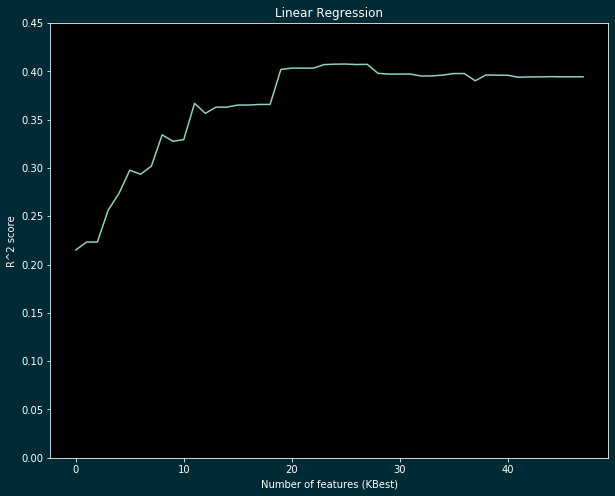

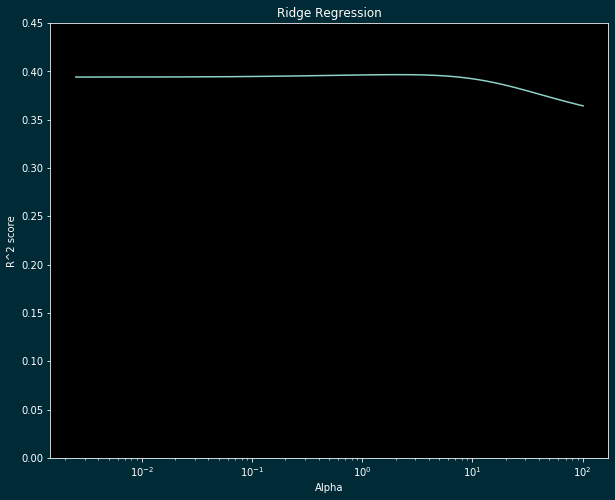

In [23]:
import matplotlib.pyplot as pyplot
pyplot.rcParams['figure.facecolor'] = '#002B36'
pyplot.rcParams['axes.facecolor'] = 'black'
pyplot.rcParams['figure.figsize'] = (10,8)

pyplot.plot(r2s_linear)
pyplot.title('Linear Regression')
pyplot.xlabel('Number of features (KBest)')
pyplot.ylabel('R^2 score')
pyplot.ylim(0, .45)
pyplot.show()

pyplot.plot(alphas, r2s_ridge)
pyplot.title('Ridge Regression')
pyplot.xlabel('Alpha')
pyplot.xscale('log')
pyplot.ylabel('R^2 score')
pyplot.ylim(0, .45)
pyplot.show()


